In [ ]:
# Sistema: unzip/unrar para extraer .rar
!apt-get -qq update
!apt-get -qq install -y unrar

# Python: utilidades
!pip -q install numpy pandas scipy h5py tqdm


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [ ]:
import os, subprocess

url_base = "https://groups.uni-paderborn.de/kat/BearingDataCenter"
files = ["K001.rar", "KA01.rar", "KI01.rar", "KA22.rar", "KI14.rar", "KB23.rar"]

os.makedirs("/content/PU_rars", exist_ok=True)

for f in files:
    url = f"{url_base}/{f}"
    out = f"/content/PU_rars/{f}"
    print(f"↓ Descargando {f} ...")
    subprocess.run(["wget", "-c", "--show-progress", "-O", out, url], check=True)


↓ Descargando K001.rar ...
↓ Descargando KA01.rar ...
↓ Descargando KI01.rar ...
↓ Descargando KA22.rar ...
↓ Descargando KI14.rar ...
↓ Descargando KB23.rar ...


In [ ]:
import glob
out_dir = "/content/PU_extracted_root"
os.makedirs(out_dir, exist_ok=True)

rar_files = sorted(glob.glob("/content/PU_rars/*.rar"))

for rp in rar_files:
    base = os.path.splitext(os.path.basename(rp))[0]  # ej. K001
    dest = os.path.join(out_dir, base)
    os.makedirs(dest, exist_ok=True)
    print(f"↪️ Extrayendo {os.path.basename(rp)} -> {dest}")
    res = subprocess.run(["unrar", "x", "-o+", "-y", "-inul", rp, dest])
    if res.returncode != 0:
        print("⚠️ Error al extraer:", rp)

print("✅ Extracción terminada.")

↪️ Extrayendo K001.rar -> /content/PU_extracted_root/K001
↪️ Extrayendo KA01.rar -> /content/PU_extracted_root/KA01
↪️ Extrayendo KA22.rar -> /content/PU_extracted_root/KA22
↪️ Extrayendo KB23.rar -> /content/PU_extracted_root/KB23
↪️ Extrayendo KI01.rar -> /content/PU_extracted_root/KI01
↪️ Extrayendo KI14.rar -> /content/PU_extracted_root/KI14
✅ Extracción terminada.


In [ ]:
for root, _, files in os.walk(out_dir):
    mats = [f for f in files if f.lower().endswith('.mat')]
    if mats:
        rel = os.path.relpath(root, out_dir)
        print(f"{rel:15s} -> {len(mats)} .mat")


KA01/KA01       -> 80 .mat
KA22/KA22       -> 80 .mat
KB23/KB23       -> 80 .mat
K001/K001       -> 80 .mat
KI14/KI14       -> 80 .mat
KI01/KI01       -> 80 .mat


In [ ]:
import numpy as np

def is_mat_v73(path):
    # v7.3 es HDF5: firma b'\x89HDF\r\n\x1a\n'
    with open(path, 'rb') as f:
        head = f.read(8)
    return head == b'\x89HDF\r\n\x1a\n'

formats = {"v5":0, "v7.3":0, "other":0}
for root, _, files in os.walk(out_dir):
    for fn in files:
        if fn.lower().endswith(".mat"):
            fpath = os.path.join(root, fn)
            if is_mat_v73(fpath):
                formats["v7.3"] += 1
            else:
                try:
                    # intentamos cargar un header rápido con scipy
                    from scipy.io import loadmat
                    loadmat(fpath, struct_as_record=False, squeeze_me=True)
                    formats["v5"] += 1
                except Exception:
                    formats["other"] += 1

print("Resumen de formatos encontrados:")
print(formats)


Resumen de formatos encontrados:
{'v5': 480, 'v7.3': 0, 'other': 0}


Archivo: /content/PU_extracted_root/K001/K001/N15_M01_F10_K001_11.mat
Longitud de la señal: 256001


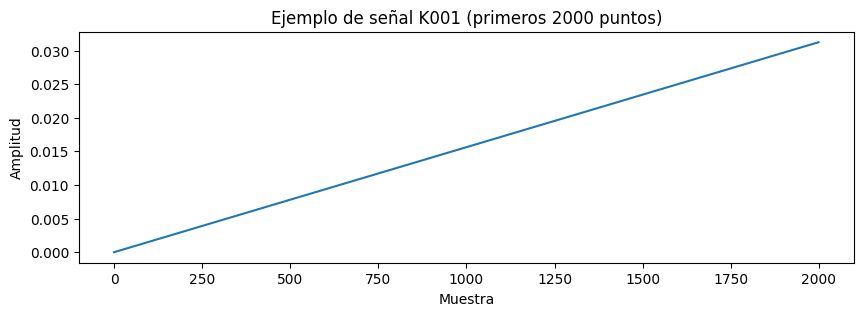

In [ ]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt

def flatten_candidates(obj):
    """Explora recursivamente y devuelve arrays numéricos encontrados."""
    cands = []
    if isinstance(obj, np.ndarray):
        if obj.dtype == object:
            for x in obj.ravel():
                cands.extend(flatten_candidates(x))
        else:
            cands.append(np.asarray(obj))
    elif hasattr(obj, "__dict__"):  # caso mat_struct
        for v in obj.__dict__.values():
            cands.extend(flatten_candidates(v))
    return cands

def extract_signal(path, min_len=1000):
    mat = loadmat(path, struct_as_record=False, squeeze_me=True)
    cands = []
    for k,v in mat.items():
        if not k.startswith("__"):
            cands.extend(flatten_candidates(v))
    # escoger el vector 1D más largo
    best = None
    best_len = -1
    for a in cands:
        arr = np.array(a).squeeze()
        if arr.ndim == 1 and arr.size > best_len:
            best, best_len = arr, arr.size
    return best

# --- probar con un archivo de K001 ---
sample_file = "/content/PU_extracted_root/K001/K001/N15_M01_F10_K001_11.mat"
sig = extract_signal(sample_file)

print("Archivo:", sample_file)
print("Longitud de la señal:", len(sig))

# graficar primeros 2000 samples
plt.figure(figsize=(10,3))
plt.plot(sig[:2000])
plt.title("Ejemplo de señal K001 (primeros 2000 puntos)")
plt.xlabel("Muestra")
plt.ylabel("Amplitud")
plt.show()


In [ ]:
import os, glob, subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.signal import resample_poly
from scipy.stats import skew, kurtosis
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier


In [ ]:
def flatten_candidates(obj):
    cands = []
    if isinstance(obj, np.ndarray):
        if obj.dtype == object:
            for x in obj.ravel():
                cands.extend(flatten_candidates(x))
        else:
            cands.append(np.asarray(obj))
    elif hasattr(obj, "__dict__"):  # caso mat_struct
        for v in obj.__dict__.values():
            cands.extend(flatten_candidates(v))
    return cands

def extract_signal(path, min_len=1000):
    mat = loadmat(path, struct_as_record=False, squeeze_me=True)
    cands = []
    for k,v in mat.items():
        if not k.startswith("__"):
            cands.extend(flatten_candidates(v))
    best, best_len = None, -1
    for a in cands:
        arr = np.array(a).squeeze()
        if arr.ndim == 1 and arr.size > best_len:
            best, best_len = arr, arr.size
    return best

def preprocess_and_segment(sig, fs_target=4000, seg_sec=1.0):
    # 1) quitar NaN/Inf
    sig = np.nan_to_num(sig, nan=0.0, posinf=0.0, neginf=0.0)
    # 2) remover media y normalizar RMS
    sig = sig - np.mean(sig)
    sig = sig / (np.sqrt(np.mean(sig**2)) + 1e-12)
    # 3) re-muestrear (asumimos fs_in ≈ 64kHz → reducimos a 4kHz)
    fs_in = 64000 if sig.size >= 200000 else max(8000, sig.size//4)
    g = np.gcd(fs_in, fs_target)
    sig = resample_poly(sig, fs_target//g, fs_in//g)
    # 4) segmentar
    seg_len = int(fs_target * seg_sec)
    n = sig.size // seg_len
    return sig[:n*seg_len].reshape(n, seg_len)

def extract_features(window):
    feats = {}
    feats["mean"] = np.mean(window)
    feats["var"] = np.var(window)
    feats["rms"] = np.sqrt(np.mean(window**2))
    feats["skew"] = skew(window)
    feats["kurtosis"] = kurtosis(window)
    feats["energy"] = np.sum(window**2)
    feats["peak"] = np.max(np.abs(window))
    feats["crest_factor"] = feats["peak"] / (feats["rms"]+1e-12)
    return feats


In [ ]:
out_dir = "/content/PU_extracted_root"

label_map = {
    "K001":"healthy",
    "KA01":"outer", "KA22":"outer",
    "KI01":"inner", "KI14":"inner",
    "KB23":"combined"
}

rows = []
for setname, label in label_map.items():
    mat_files = glob.glob(os.path.join(out_dir, setname, "**/*.mat"), recursive=True)
    for f in mat_files:
        sig = extract_signal(f)
        windows = preprocess_and_segment(sig, fs_target=4000, seg_sec=1.0)
        for w in windows:
            feats = extract_features(w)
            feats["label"] = label
            feats["set"] = setname
            rows.append(feats)

df = pd.DataFrame(rows)
print("Tamaño final del dataset:", df.shape)
df.head()


Tamaño final del dataset: (1920, 10)


,mean,var,rms,skew,kurtosis,energy,peak,crest_factor,label,set
0,-1.299091,0.062484,1.322921,-1.634050e-03,-1.197164,7000.480355,1.883058,1.423409,healthy,K001
1,-0.433495,0.062463,0.500381,-1.870242e-09,-1.200000,1001.523926,0.866272,1.731226,healthy,K001
2,0.432277,0.062463,0.499326,1.635475e-09,-1.200000,997.307647,0.865055,1.732443,healthy,K001
3,1.298049,0.062463,1.321890,1.842741e-07,-1.199999,6989.577089,1.733936,1.311710,healthy,K001
4,-1.299115,0.062481,1.322943,-1.634017e-03,-1.197164,7000.717988,1.883072,1.423395,healthy,K001


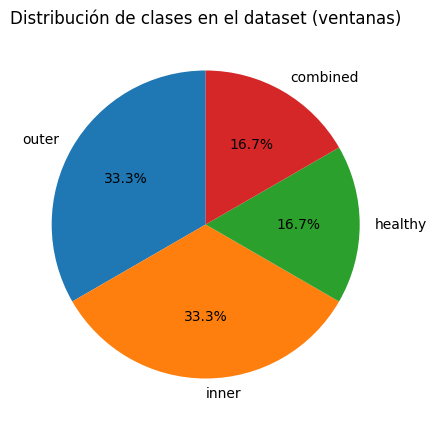

In [ ]:
counts = df["label"].value_counts()
plt.figure(figsize=(5,5))
plt.pie(counts, labels=counts.index, autopct="%1.1f%%", startangle=90)
plt.title("Distribución de clases en el dataset (ventanas)")
plt.show()



===  SVM (RBF)  ===
              precision    recall  f1-score   support

    combined       0.00      0.00      0.00        96
     healthy       0.00      0.00      0.00        96
       inner       0.38      0.10      0.16       192
       outer       0.34      0.93      0.50       192

    accuracy                           0.35       576
   macro avg       0.18      0.26      0.17       576
weighted avg       0.24      0.35      0.22       576



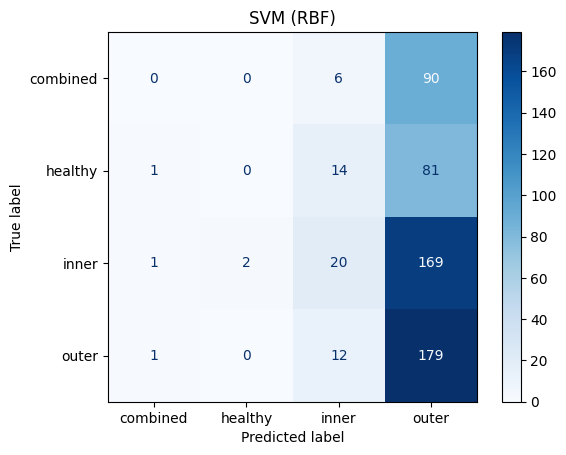


===  Random Forest  ===
              precision    recall  f1-score   support

    combined       0.20      0.19      0.19        96
     healthy       0.22      0.21      0.21        96
       inner       0.38      0.40      0.39       192
       outer       0.49      0.49      0.49       192

    accuracy                           0.36       576
   macro avg       0.32      0.32      0.32       576
weighted avg       0.36      0.36      0.36       576



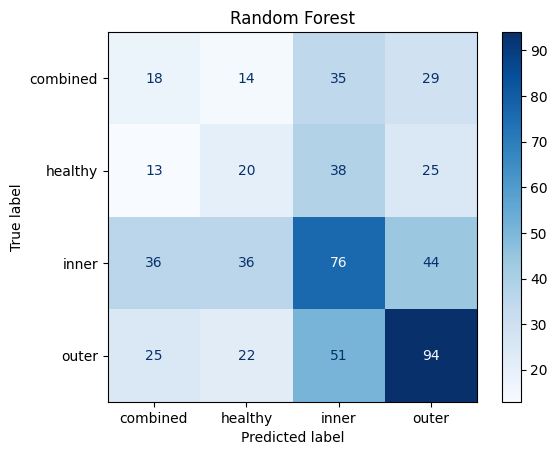


===  Decision Tree  ===
              precision    recall  f1-score   support

    combined       0.21      0.09      0.13        96
     healthy       0.21      0.16      0.18        96
       inner       0.36      0.54      0.43       192
       outer       0.50      0.46      0.48       192

    accuracy                           0.38       576
   macro avg       0.32      0.31      0.31       576
weighted avg       0.36      0.38      0.36       576



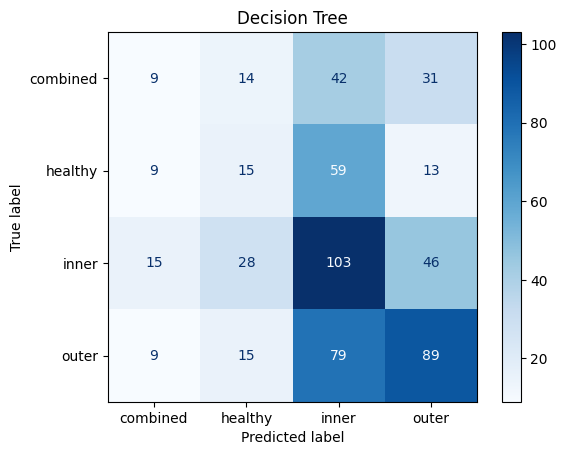

In [ ]:
X = df.drop(columns=["label","set"])
y = df["label"]

# Escalar features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y)

models = {
    "SVM (RBF)": SVC(kernel="rbf", C=10, gamma="scale"),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "Decision Tree": DecisionTreeClassifier(max_depth=10, random_state=42)
}

for name, model in models.items():
    print("\n=== ", name, " ===")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues")
    plt.title(name)
    plt.show()


In [ ]:
from sklearn.metrics import cohen_kappa_score

models = {
    "SVM (RBF)": SVC(kernel="rbf", C=10, gamma="scale"),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "Decision Tree": DecisionTreeClassifier(max_depth=10, random_state=42)
}

results = []
for name, model in models.items():
    print("\n=== ", name, " ===")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calcular Cohen Kappa
    kappa = cohen_kappa_score(y_test, y_pred)
    results.append((name, kappa))

    print("Cohen Kappa:", round(kappa, 3))

# Mostrar resumen comparativo
print("\n📊 Resumen Cohen Kappa:")
for name, kappa in results:
    print(f"{name:15s} -> {kappa:.3f}")



===  SVM (RBF)  ===
Cohen Kappa: 0.02

===  Random Forest  ===
Cohen Kappa: 0.113

===  Decision Tree  ===
Cohen Kappa: 0.107

📊 Resumen Cohen Kappa:
SVM (RBF)       -> 0.020
Random Forest   -> 0.113
Decision Tree   -> 0.107
